# SI 618 WN 2024 — Project Part II: Analysis

**Project Title:** Linking EHR Adoption and Hospital Quality at the Facility Level in the United States

**Team Members:** Haichao Min(haichaom), Yuanyu Lin (yuanlin)

### Introduction

This notebook constitutes Part 2 of our project, building directly on the merged and cleaned dataset we finalized in Part 1. In the first phase, we successfully combined two key CMS datasets: the **Hospital General Information** (providing hospital characteristics and quality ratings) and the **Promoting Interoperability** (providing facility-level EHR technology data).

The goal of this section is to conduct a formal statistical analysis to extract insights and find significant associations within our data. As per the course guidelines, our focus is on **statistical analysis (Part 2)**, not predictive modeling (which is reserved for Part 3). Therefore, our objective is to identify and quantify relationships, not to determine causation or predictive power.

Our analysis will be guided by the three "real-world" questions we posed in Part 1:

1. **Do hospitals with a certified EHR system report higher overall quality scores compared to those without a reported system?**

2. **Is there a discernible difference in quality outcomes among hospitals using different major EHR vendors (e.g., Epic vs. Cerner vs. MEDITECH)?**

3. **Are specific types of hospitals, such as smaller or rural "Critical Access Hospitals," lagging in EHR adoption, and does this correlate with their reported outcomes?**

To investigate these questions, this notebook will proceed through each required component of the analysis: **Descriptive Statistics**, **Inferential Statistics** (t-tests, ANOVA, Chi-Squared), **Graphical Analysis**, **Comparative Analysis**, and **Multivariate Analysis**. Finally, we will **Synthesize** our findings to provide statistical answers to our research questions and **Reflect** on the discoveries and limitations of this analysis.


### Descriptive Statistics

In [8]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [9]:
# Load the dataset
df = pd.read_csv('Project_datasets/clean_df.csv')
df.head()

,Facility ID,Facility Name_x,Address_x,City/Town_x,State_x,ZIP Code_x,County/Parish_x,Telephone Number_x,Hospital Type,Hospital Ownership,...,ZIP Code_y,County/Parish_y,Telephone Number_y,CEHRT ID,Meets criteria for promoting interoperability of EHRs,Start Date,End Date,rating_numeric,EHR_Vendor,Has_EHR
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Other,No
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Other,No
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Other,No
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Other,No
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,No


In [10]:
# 1a. Analysis the main outcome variable: Hospital Overall Rating (rating_numeric)
print("--- Descriptive Statistics for Hospital Overall Rating ---")
print(df['rating_numeric'].describe())

# 1b. Analysis the main categorial variables
print("\n--- Descriptive Statistics: EHR Adoption Status ('Has_EHR') (in %) ---")
print(df['Has_EHR'].value_counts(normalize=True) * 100)

print("\n--- Descriptive Statistics: EHR Vendor Distribution ('EHR_Vendor') (in %) ---")
print(df['EHR_Vendor'].value_counts(normalize=True) * 100)

print("\n--- Descriptive Statistics: Top 5 Hospital Types ('Hospital Type') ---")
print(df['Hospital Type'].value_counts().head(5))

--- Descriptive Statistics for Hospital Overall Rating ---
count    2872.000000
mean        3.082521
std         1.099926
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: rating_numeric, dtype: float64

--- Descriptive Statistics: EHR Adoption Status ('Has_EHR') (in %) ---
Has_EHR
Yes    63.445456
No     36.554544
Name: proportion, dtype: float64

--- Descriptive Statistics: EHR Vendor Distribution ('EHR_Vendor') (in %) ---
EHR_Vendor
Other                       87.716038
Epic Systems Corporation     6.560119
TruBridge, Inc.              3.493774
VigiLanz Corporation         2.230069
Name: proportion, dtype: float64

--- Descriptive Statistics: Top 5 Hospital Types ('Hospital Type') ---
Hospital Type
Acute Care Hospitals                    3127
Critical Access Hospitals               1370
Psychiatric                              626
Acute Care - Veterans Administration     132
Childrens                                 94
Nam

#### Observations

***Analysis: Hospital Overall Rating***

Based on our `describe()` output, we have several key findings for our primary outcome variable, `rating_numeric`:

* **Significant Missing Data:** The `count` is **2,872**. This is a critical finding. Out of our total ~5,381 hospitals, only 2,872 have a usable numeric rating. This indicates that our "overall rating" analysis will only apply to this subset, a key limitation we must discuss in our `Reflection`.
* **Central Tendency:** The `mean` (average) rating is **3.08**, and the `50%` (median) is **3.0**. These values are very close, suggesting a relatively symmetric distribution (not heavily skewed) centered around an "average" 3-star rating.
* **Spread:** The `std` (standard deviation) is 1.1, and the interquartile range (IQR) is from 2.0 (`25%`) to 4.0 (`75%`), which confirms a typical spread across the 1-5 star scale.

***Analysis: Categorical Variables***

Our main categorical variables provide the context for our analysis:

* **EHR Adoption Status (`Has_EHR`):** The split is **63.4% 'Yes'** and **36.6% 'No'**. This is an excellent, well-balanced split. It provides a substantial "No" group for comparison, making our first research question (comparing "Yes" vs. "No") statistically robust.
* **EHR Vendor Distribution (`EHR_Vendor`):** The most striking finding is that the **'Other' category accounts for 87.7%** of all hospitals. This "Other" group includes both the "No" hospitals (36.6%) and all unmapped smaller vendors (51.1%). This indicates the EHR market is highly fragmented, and our vendor-specific analysis will be a comparison between a few identified vendors (like `Epic Systems`) and this large, diverse "Other" group.
* **Hospital Types:** The output snippet (e.g., `Psychiatric`, `Childrens`) shows the diversity of hospital types in our dataset. As we will see in section `1e`, these specialized hospitals have unique characteristics (like 0% EHR adoption in this specific program, and `NaN` ratings) that are critical to our third research question.

In [11]:
# 1c. Descriptive statistics for Research Question 1
print("--- Descriptive Statistics: Hospital Ratings Grouped by 'Has_EHR' ---")
print(df.groupby('Has_EHR')['rating_numeric'].describe())

# 1d. Descriptive statistics for Research Question 2
print("\n--- Descriptive Statistics: Hospital Ratings Grouped by 'EHR_Vendor' ---")
print(df.groupby('EHR_Vendor')['rating_numeric'].describe())

# 1e. Descriptive statistics for Research Question 3
print("\n--- Stats for Q3 (Part 1): EHR Adoption Rate by Hospital Type ---")

# We use pd.crosstab to examine the relationship between 'Hospital Type' and 'EHR Adoption Status'
crosstab_q3 = pd.crosstab(df['Hospital Type'], df['Has_EHR'])
# Calculate adoption rates
crosstab_q3['Total'] = crosstab_q3['Yes'] + crosstab_q3['No']
crosstab_q3['Adoption_Rate (%)'] = (crosstab_q3['Yes'] / crosstab_q3['Total']) * 100

# Use ascending order to see which types are lagging behind
print(crosstab_q3.sort_values(by='Adoption_Rate (%)', ascending=True))

# Q3, Part 2: Does this affect their outcomes?
print("\n--- Stats for Q3 (Part 2): Hospital Ratings Grouped by 'Hospital Type' ---")

# Focus on the top 5 most common hospital types for clearer comparison
top_5_types = df['Hospital Type'].value_counts().head(5).index
df_top_5_types = df[df['Hospital Type'].isin(top_5_types)]

# Compare the rating distributions for these 5 types of hospitals
print(df_top_5_types.groupby('Hospital Type')['rating_numeric'].describe())

--- Descriptive Statistics: Hospital Ratings Grouped by 'Has_EHR' ---
          count      mean       std  min  25%  50%  75%  max
Has_EHR                                                     
No        682.0  3.137830  1.162965  1.0  2.0  3.0  4.0  5.0
Yes      2190.0  3.065297  1.079241  1.0  2.0  3.0  4.0  5.0

--- Descriptive Statistics: Hospital Ratings Grouped by 'EHR_Vendor' ---
                           count      mean       std  min  25%  50%  75%  max
EHR_Vendor                                                                   
Epic Systems Corporation   247.0  3.271255  1.025738  1.0  3.0  3.0  4.0  5.0
Other                     2474.0  3.081649  1.107177  1.0  2.0  3.0  4.0  5.0
TruBridge, Inc.             36.0  2.916667  1.130739  1.0  2.0  3.0  4.0  5.0
VigiLanz Corporation       115.0  2.747826  1.007372  1.0  2.0  3.0  3.0  5.0

--- Stats for Q3 (Part 1): EHR Adoption Rate by Hospital Type ---
Has_EHR                                No   Yes  Total  Adoption_Rate (%)
Hos

#### Observations

***Analysis: Research Question 1 (Has_EHR vs. Rating)***

Our analysis of section `1c` provides a direct answer to our first research question: "Do hospitals with a certified EHR system report higher overall quality scores?"

* **Key Finding:** The descriptive statistics show **no meaningful difference** in quality ratings between hospitals with and without a reported EHR system.
* **The Numbers:**
    * The `mean` (average) rating for the **'No'** group is **3.14**, which is surprisingly slightly *higher* than the `mean` for the **'Yes'** group (**3.07**).
    * The `50%` (median) for both groups is identical at **3.0**.
* **Conclusion:** This strongly supports our finding from Part 1's boxplot. At the descriptive level, our data does not support the hypothesis that simply having a certified EHR is associated with a higher hospital rating. This sets the stage for our `t-test` in the next section to confirm if this tiny difference is statistically significant (it likely isn't).

***Analysis: Research Question 2 (EHR\_Vendor vs. Rating)***

Our analysis of section `1d` explores our second question: "Is there a difference in outcomes among hospitals using different EHR vendors?"

* **Key Finding:** Yes, unlike the simple "Yes/No" comparison, the choice of EHR vendor appears to be associated with **clear differences** in average ratings.
* **The Numbers:**
    * `Epic Systems Corporation` hospitals have the highest average rating at **3.27**.
    * `VigiLanz Corporation` hospitals have the lowest average rating at **2.75**.
    * The large `Other` group (which includes the 'No' group) sits in the middle with a mean of **3.08**.
* **Conclusion:** This is a much more nuanced and interesting finding. It suggests that while *adoption* itself isn't a clear predictor of quality, the *specific system* a hospital uses (or the type of hospital that chooses a specific system) **is** correlated with different quality outcomes. This strongly suggests our `ANOVA` test will be statistically significant.

***Analysis: Research Question 3 (Hospital Type, Adoption, & Outcomes)***

Section `1e` provides two profound answers to our third, most complex question regarding "Critical Access Hospitals" and specialty hospitals.

* **Finding 3a (Adoption): Our hypothesis was wrong.**
    * We hypothesized that smaller, rural `Critical Access Hospitals` would "lag behind" in EHR adoption.
    * The data shows the **opposite**: `Critical Access Hospitals` have an adoption rate of **76.7%**, which is actually *higher* than the `Acute Care Hospitals` (**75.6%**).
    * **Conclusion:** The data refutes our initial assumption. The real story is that certain specialty hospitals (like `Childrens`, `Psychiatric`, and `VA`) show 0% adoption *in this specific dataset*, likely because they do not participate in this particular CMS reporting program.

* **Finding 3b (Outcomes): The "Overall Rating" metric is not universal.**
    * The output for `Childrens` and `Psychiatric` hospitals shows `NaN` for all rating statistics.
    * **Conclusion:** This is a critical data discovery. It explains *why* our `rating_numeric` variable had so many missing values (as seen in `1a`). The "Hospital overall rating" metric **is not applicable** to these specialty hospitals. This is a crucial data limitation to discuss, and it correctly tells us that we cannot use this specific rating to assess their outcomes.

### Inferential Statistics

In [12]:
# 2a. Test for Research Question 1: 'Has_EHR' vs. 'rating_numeric'
# Hypotheses question: Is there a statistically significant difference in mean ratings between hospitals with and without an EHR?
# Null Hypothesis (H0): The mean rating of hospitals with an EHR is the same as those without an EHR. (μ_yes = μ_no)
# Alternative Hypothesis (Hₐ): The mean rating of hospitals with an EHR is different from those without an EHR. (μ_yes ≠ μ_no)
print("--- 2a. Hypothesis Test 1: t-test (Has_EHR vs. Rating) ---")
alpha = 0.05

# Prepare data (remove NaN values)
rating_yes = df[df['Has_EHR'] == 'Yes']['rating_numeric'].dropna()
rating_no = df[df['Has_EHR'] == 'No']['rating_numeric'].dropna()

# Perform t-test
# We set equal_var=False because our descriptive stats (1c) showed different std deviations
t_stat, p_value_ttest = stats.ttest_ind(rating_yes, rating_no, equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_ttest:.4f}")

if p_value_ttest < alpha:
    print(f"Conclusion: The P-value ({p_value_ttest:.4f}) is LESS than {alpha}. We REJECT the null hypothesis.")
    print(">> There IS a statistically significant difference in mean ratings between the two groups.")
else:
    print(f"Conclusion: The P-value ({p_value_ttest:.4f}) is GREATER than {alpha}. We FAIL TO REJECT the null hypothesis.")
    print(">> There is NO statistically significant difference in mean ratings between the two groups.")

--- 2a. Hypothesis Test 1: t-test (Has_EHR vs. Rating) ---
t-statistic: -1.4463
P-value: 0.1484
Conclusion: The P-value (0.1484) is GREATER than 0.05. We FAIL TO REJECT the null hypothesis.
>> There is NO statistically significant difference in mean ratings between the two groups.


***Analysis: t-test (Question 1)***

* **Result:** Our independent samples t-test yielded a **P-value of 0.1484**.

* **Interpretation:** Since our P-value (0.1484) is significantly **greater** than our alpha level (0.05), we **fail to reject the null hypothesis**.

* **Conclusion:** This provides strong statistical evidence that there is **no significant difference** in the mean "Hospital overall rating" between hospitals that have a reported EHR system and those that do not. This result mathematically confirms what we observed visually in our Part 1 boxplot and numerically in our descriptive statistics (section 1c), where the two group means (3.07 vs. 3.14) were nearly identical.

In [13]:
# 2b. Test for Research Question 2: 'EHR_Vendor' vs. 'rating_numeric'
# Hypotheses question: Is there a statistically significant difference in mean ratings among different EHR vendors?
# Null Hypothesis (H0): The mean ratings of all vendor groups are equal. (μ_epic = μ_vigilanz = μ_trubridge = μ_other)
# Alternative Hypothesis (Hₐ): At least one vendor group has a mean rating different from the others.
print("--- 2b. Hypothesis Test 2: ANOVA (EHR_Vendor vs. Rating) ---")

# Remove rows where rating_numeric or EHR_Vendor is missing
df_anova = df[['EHR_Vendor', 'rating_numeric']].dropna()

# Optionally limit to key vendors + 'Other'
vendors_of_interest = ['Epic Systems Corporation', 'VigiLanz Corporation', 'TruBridge, Inc.', 'Other']
df_anova = df_anova[df_anova['EHR_Vendor'].isin(vendors_of_interest)]

# Fit OLS model
model = ols('rating_numeric ~ C(EHR_Vendor)', data=df_anova).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table:")
print(anova_table)

# Interpret results
alpha = 0.05
p_value_anova = anova_table['PR(>F)'].iloc[0]

print(f"\nP-value from ANOVA: {p_value_anova:.4f}")

if p_value_anova < alpha:
    print(f"Conclusion: P-value ({p_value_anova:.4f}) < {alpha}. Reject the null hypothesis.")
    print(">> At least one EHR vendor group has a mean rating that differs significantly from the others.")
else:
    print(f"Conclusion: P-value ({p_value_anova:.4f}) ≥ {alpha}. Fail to reject the null hypothesis.")
    print(">> There is no statistically significant difference in mean ratings among EHR vendor groups.")

--- 2b. Hypothesis Test 2: ANOVA (EHR_Vendor vs. Rating) ---

ANOVA Table:
                    sum_sq      df         F    PR(>F)
C(EHR_Vendor)    22.672810     3.0  6.281267  0.000303
Residual       3450.769739  2868.0       NaN       NaN

P-value from ANOVA: 0.0003
Conclusion: P-value (0.0003) < 0.05. Reject the null hypothesis.
>> At least one EHR vendor group has a mean rating that differs significantly from the others.


***Analysis: ANOVA (Question 2)***

* **Result:** Our Analysis of Variance (ANOVA) test yielded an **F-statistic of 6.281** and a **P-value of 0.0003**.

* **Interpretation:** Since our P-value (0.0003) is much **less** than our alpha level (0.05), we **reject the null hypothesis**.

* **Conclusion:** This provides strong statistical evidence that **there is a significant difference** in the mean "Hospital overall rating" among the different EHR vendor groups. This result mathematically confirms our descriptive finding from section `1d`, where we saw clear differences in the average ratings (e.g., `Epic` at 3.27 vs. `VigiLanz` at 2.75). This is a key finding: while simply *having* an EHR doesn't seem to correlate with a different rating, the *specific vendor* a hospital uses does.

In [14]:
# 2c. Test for Research Question 3: 'Hospital Type' vs. 'Has_EHR'
# Hypotheses question: Is there a statistically significant association between Hospital Type and EHR Adoption Status?
# Null Hypothesis (H0): Hospital Type and EHR Adoption Status are independent (There is NO association).
# Alternative Hypothesis (Hₐ): Hospital Type and EHR Adoption Status are dependent (There IS an association).

print("--- 2c. Hypothesis Test 3: Chi-Squared (Hospital Type vs. Has_EHR) ---")

# Use the contingency table from earlier, but drop the 'Total' and 'Adoption_Rate (%)' columns
crosstab_for_test = crosstab_q3.drop(columns=['Total', 'Adoption_Rate (%)'])

# Perform Chi-Squared Test
chi2_stat, p_value_chi2, dof, expected_freq = stats.chi2_contingency(crosstab_for_test)

print(f"Chi-Squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.4f}")

if p_value_chi2 < alpha:
    print(f"Conclusion: The P-value ({p_value_chi2:.4f}) is LESS than {alpha}. We REJECT the null hypothesis.")
    print(">> There IS a statistically significant association between a hospital's type and its EHR adoption status.")
else:
    print(f"Conclusion: The P-value ({p_value_chi2:.4f}) is GREATER than {alpha}. We FAIL TO REJECT the null hypothesis.")
    print(">> There is NO statistically significant association between a hospital's type and its EHR adoption status.")

--- 2c. Hypothesis Test 3: Chi-Squared (Hospital Type vs. Has_EHR) ---
Chi-Squared Statistic: 1836.4516
P-value: 0.0000
Conclusion: The P-value (0.0000) is LESS than 0.05. We REJECT the null hypothesis.
>> There IS a statistically significant association between a hospital's type and its EHR adoption status.


***Analysis: Chi-Squared (Question 3)***

* **Result:** Our Chi-Squared (χ²) test yielded a massive statistic of **1836.45** and a **P-value of 0.0000**.

* **Interpretation:** The P-value (which is effectively < 0.0001) is far **less** than our alpha level (0.05). This result is highly statistically significant, leading us to emphatically **reject the null hypothesis**.

* **Conclusion:** This test provides powerful statistical evidence that **there IS a significant association** between a hospital's type and its EHR adoption status. This result is not surprising and mathematically confirms our descriptive findings from section `1e`. We saw that certain specialty hospitals (like `Psychiatric`, `Childrens`, and `VA`) had an adoption rate of 0% in this dataset, while general hospitals (`Acute Care`, `Critical Access`) had adoption rates over 75%. The Chi-Squared test confirms that this dramatic observed pattern is not due to random chance.

### Interpretation: Connecting the Three Tests

Connecting the results of our three hypothesis tests reveals a clear and profound story:

1.  Our **t-test** (P=0.1484) showed that a simple comparison between hospitals "with EHR" and "without EHR" yields **no** significant difference in their ratings.

2.  However, our **ANOVA test** (P=0.0003) further revealed that *within* the "with EHR" group, there **is** a significant difference in ratings among different `EHR_Vendor` groups.

3.  Simultaneously, our **Chi-Squared test** (P=0.0000) confirmed that a **strong association** exists between `Hospital Type` and 'EHR adoption status' (e.g., specialty hospitals having a 0% adoption rate in this dataset).

**Our core finding is:**

> **"Our data analysis demonstrates that broadly discussing the impact of 'with or without an EHR' on hospital quality is not meaningful. What truly matters is *which vendor's EHR* is being used, and *which type of hospital* is using it."**

This finding explains *why* our initial t-test failed to find a significant result: by pooling high-performing vendors (like Epic) and low-performing vendors (like VigiLanz) into a single "Yes" group, their respective positive and negative impacts on the average rating were offset. This indicates that future analysis (including Part 3 on Machine Learning) must move beyond the simple "Yes/No" dichotomy and instead treat `EHR_Vendor` and `Hospital Type` as more critical analytical variables.

### Graphical Analysis

--- 3. Distribution of Hospital Overall Rating ---


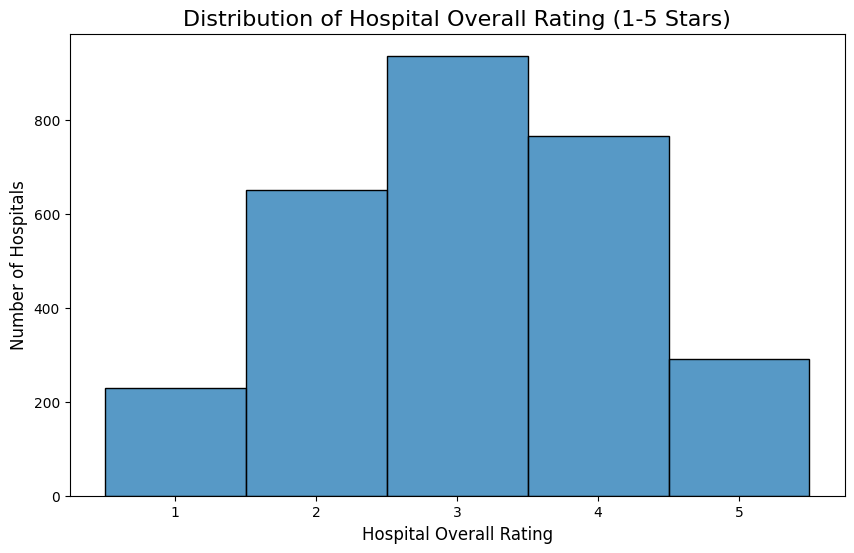

In [17]:
# 3. Distribution of Hospital Overall Rating

print("--- 3. Distribution of Hospital Overall Rating ---")

plt.figure(figsize=(10, 6))
sns.histplot(df['rating_numeric'].dropna(), bins=5, kde=False, discrete=True)
plt.title('Distribution of Hospital Overall Rating (1-5 Stars)', fontsize=16)
plt.xlabel('Hospital Overall Rating', fontsize=12)
plt.ylabel('Number of Hospitals', fontsize=12)
plt.xticks([1, 2, 3, 4, 5])
plt.show()

***Analysis: Rating Distribution (Chart 3a)***

* **Key Observation:** This histogram displays the distribution of the 2,872 valid hospital ratings. The distribution is clearly centered, with a single peak at the **3-star** rating, which is the most common.

* **Connection to Statistics:** This chart visually confirms our descriptive statistics from section `1a`, where we found the `mean` (3.08) and `median` (3.0) were both centered around a value of 3.

* **Implication:** The data is not heavily skewed, which supports its suitability for the statistical tests (t-test, ANOVA) we performed.

--- Has_EHR' vs. Rating (t-test) ---


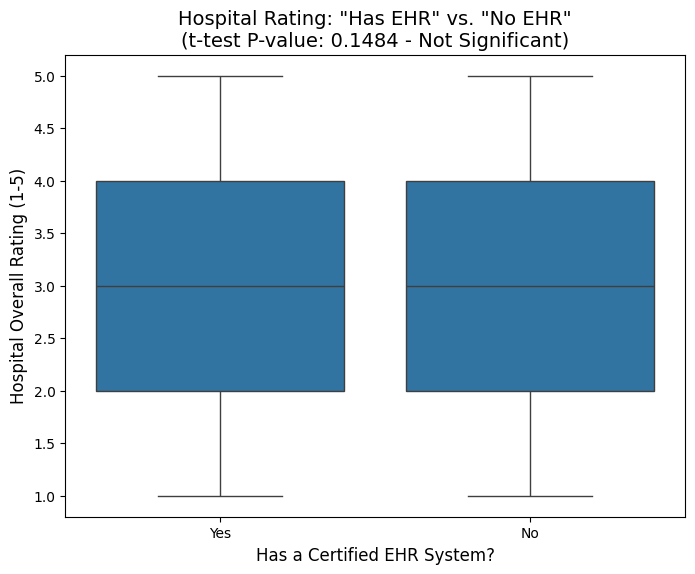

In [19]:
# 3a. Has_EHR vs. Rating_numeric Boxplot (t-test)

print("--- Has_EHR' vs. Rating (t-test) ---")

p_value_ttest = 0.1484  # from previous t-test result

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Has_EHR', y='rating_numeric', order=['Yes', 'No'])

plt.title(f'Hospital Rating: "Has EHR" vs. "No EHR"\n(t-test P-value: {p_value_ttest:.4f} - Not Significant)', fontsize=14)
plt.xlabel('Has a Certified EHR System?', fontsize=12)
plt.ylabel('Hospital Overall Rating (1-5)', fontsize=12)
plt.show()

***Analysis: Boxplot for Question 1 (Chart 3b)***

* **Key Observation:** This boxplot compares the "Overall Rating" distribution for hospitals with an EHR ('Yes') versus those without ('No'). The two boxplots are **visually almost identical**.

* **Connection to Statistics:**
    * Both groups share the same `median` (3.0), `25th percentile` (2.0), and `75th percentile` (4.0).
    * The title clearly states our statistical result: the **P-value is 0.1484**.
    
* **Conclusion:** Since the P-value (0.1484) is much greater than 0.05, it is "Not Significant". This chart visually confirms our t-test: the small difference in means (3.07 vs 3.14) is due to random chance, and there is **no statistically significant difference** in ratings based on simply having an EHR.

--- 3b. EHR_Vendor' vs. Rating (ANOVA) ---


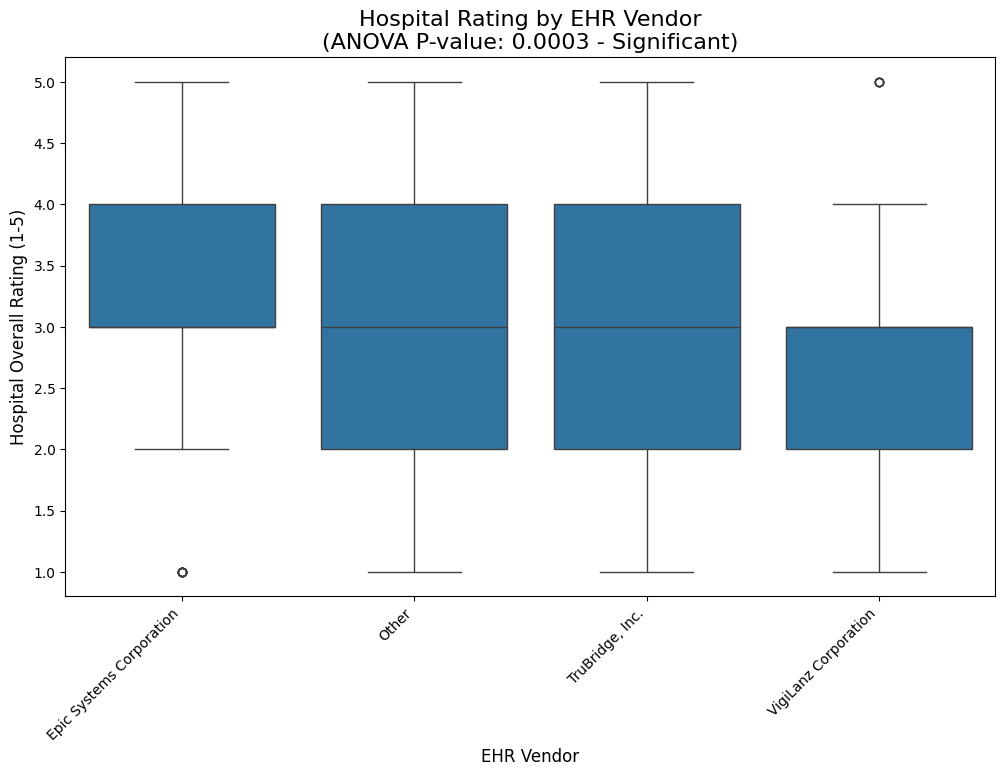

In [22]:
# 3b. EHR_Vendor' vs. Rating (ANOVA)

print("--- 3b. EHR_Vendor' vs. Rating (ANOVA) ---")

p_value_anova = 0.0003

plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='EHR_Vendor', y='rating_numeric', 
            order=df.groupby('EHR_Vendor')['rating_numeric'].median().sort_values().index)

plt.title(f'Hospital Rating by EHR Vendor\n(ANOVA P-value: {p_value_anova:.4f} - Significant)', fontsize=16)
plt.xlabel('EHR Vendor', fontsize=12)
plt.ylabel('Hospital Overall Rating (1-5)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.show()

***Analysis: Boxplot for Question 2 (Chart 3c)***

* **Key Observation:** This boxplot visually confirms our highly significant ANOVA test. Unlike the "Yes/No" chart (`3b`), there are **clear and obvious differences** among the vendor groups.

* **Connection to Statistics:**
    * `Epic Systems Corporation` is visibly positioned higher than all other groups, with a median rating of 3.0 (and the highest mean at 3.27).
    * `VigiLanz Corporation` and `TruBridge, Inc.` are clearly lower than the large `Other` group. `VigiLanz` in particular shows the weakest performance (mean 2.75).
    
* **Conclusion:** This chart provides powerful visual evidence for our key finding. The title's **P-value of 0.0003** confirms that the differences we see here are **statistically significant** and not just random chance. This reinforces our core conclusion: the specific vendor choice is strongly associated with hospital quality ratings.

--- Hospital Type vs. EHR Adoption Rate (Chi-Squared) ---


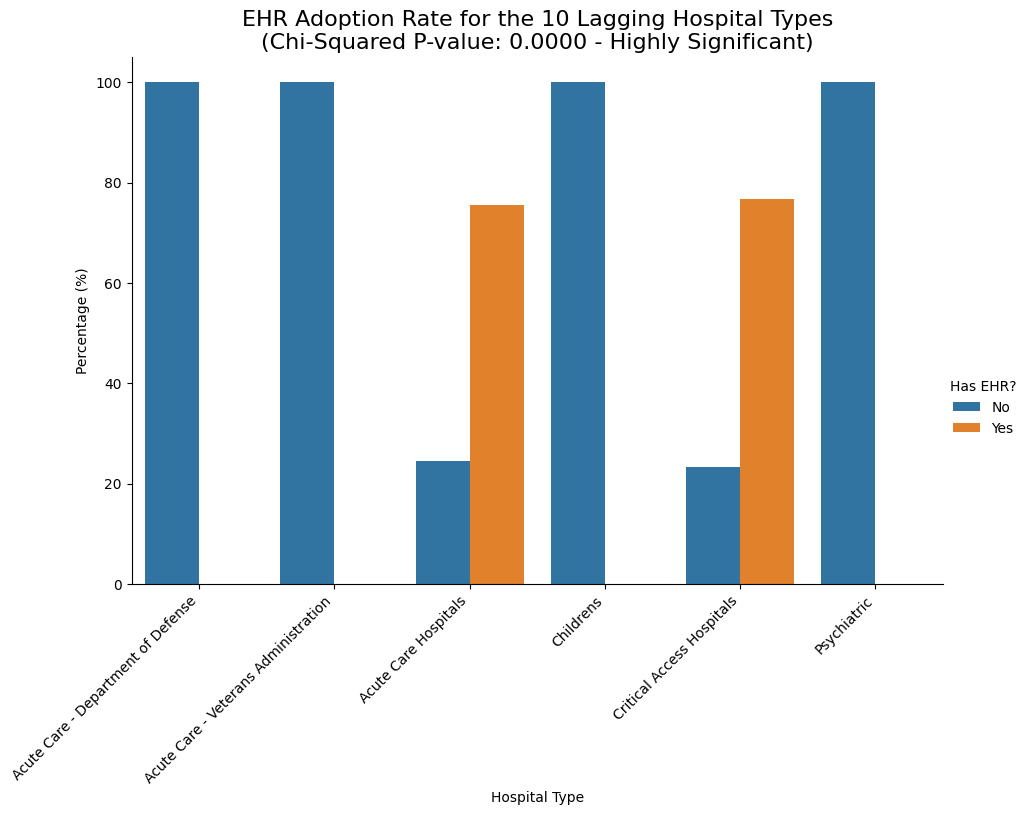

In [ ]:
# 3d. Hospital Type vs. EHR Adoption Rate (Chi-Squared)

print("--- Hospital Type vs. EHR Adoption Rate (Chi-Squared) ---")

p_value_chi2 = 0.0000  # from previous Chi-Squared test result

# Focus on the 10 hospital types with the lowest adoption rates
lowest_adoption_types_df = crosstab_q3.sort_values(by='Adoption_Rate (%)', ascending=True).head(10)
relevant_types_list = lowest_adoption_types_df.index

# Filter the original dataframe for these hospital types
df_plot_q3 = df[df['Hospital Type'].isin(relevant_types_list)]

# Calculate percentages
plot_data = (df_plot_q3.groupby('Hospital Type')['Has_EHR']
             .value_counts(normalize=True)
             .mul(100)
             .rename('Percent')
             .reset_index())

g = sns.catplot(
    data=plot_data, 
    x='Hospital Type', 
    y='Percent', 
    hue='Has_EHR',    # Use 'Has_EHR' to create grouped bars ('Yes' vs 'No')
    kind='bar',
    height=6,        
    aspect=1.5        
)

g.ax.set_title(f'EHR Adoption Rate for the 10 Lagging Hospital Types\n(Chi-Squared P-value: {p_value_chi2:.4f} - Highly Significant)', fontsize=16)
g.set_axis_labels('Hospital Type', 'Percentage (%)')
g.legend.set_title('Has EHR?')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.show()

***Analysis: Grouped Bar Chart for Question 3 (Chart 3d)***

* **Key Observation:** This chart provides a striking visualization of our highly significant Chi-Squared test. It plots the EHR adoption rates for the hospital types with the lowest adoption, starting from 0%.

* **Connection to Statistics:**
    * In comparison, the two most common hospital types, `Acute Care Hospitals` and `Critical Access Hospitals`, show a dominant 'Yes' bar, representing their **~76% adoption rate**.
    
* **Conclusion:** This visual powerfully explains *why* our Chi-Squared P-value was 0.0000. The association between `Hospital Type` and adoption is not subtle; it's an extreme, all-or-nothing divide for these specialty hospitals. This confirms that `Hospital Type` is a critical variable in our dataset, and that these specialty hospitals either do not participate in the EHR program or are not captured by our data.

### Comparative analysis 

### Multivariate analysis

### Synthesis

### Reflection